In [ ]:
pip install opencv-python scikit-image scikit-learn pillow numpy matplotlib tensorflow

In [ ]:
!pip install opencv-contrib-python --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.10.0.84
    Uninstalling opencv-contrib-python-4.10.0.84:
      Successfully uninstalled opencv-contrib-python-4.10.0.84


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


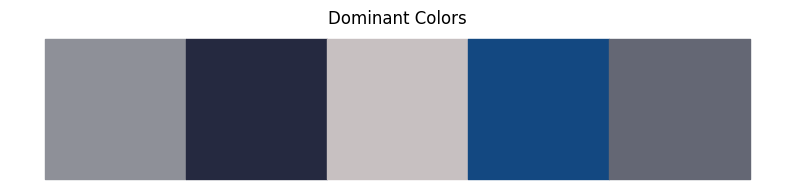

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import feature, filters, exposure
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from PIL import Image
import json
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image as tf_image

def extract_image_details(image_path):
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize results dictionary
    analysis = {
        "proportions": {},
        "color_palette": {},
        "textures": {},
        "composition": {},
        "key_features": {}
    }

    # --- Step 1: Proportions ---
    height, width = img.shape[:2]
    analysis["proportions"] = {
        "width": width,
        "height": height,
        "aspect_ratio": f"{width}:{height}"
    }

    # --- Step 2: Color Palette ---
    # Reshape image for K-means clustering
    pixels = img_rgb.reshape(-1, 3)
    kmeans = KMeans(n_clusters=5, random_state=0).fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)
    color_counts = np.unique(kmeans.labels_, return_counts=True)[1]
    color_percentages = (color_counts / color_counts.sum() * 100).round(2)

    analysis["color_palette"] = {
        "dominant_colors": dominant_colors.tolist(),
        "color_distribution": color_percentages.tolist()
    }

    # --- Step 3: Texture Analysis ---
    # Calculate GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(img_gray, distances=[1], angles=[0], symmetric=True, normed=True)
    texture_props = {
        "contrast": graycoprops(glcm, 'contrast')[0, 0].round(4),
        "energy": graycoprops(glcm, 'energy')[0, 0].round(4),
        "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0].round(4)
    }
    analysis["textures"] = texture_props

    # --- Step 4: Composition Analysis ---
    # Edge detection (Canny)
    edges = feature.canny(img_gray, sigma=3)
    # Saliency map (to identify focal points)
    saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    _, saliency_map = saliency.computeSaliency(img)

    analysis["composition"] = {
        "edge_density": np.mean(edges).round(4),  # Higher = more edges
        "saliency_hotspots": np.mean(saliency_map).round(4)  # Higher = more salient regions
    }

    # --- Step 5: Key Feature Detection ---
    # Load pre-trained VGG16 for style/feature analysis
    model = VGG16(weights='imagenet', include_top=False)
    img_tf = tf_image.load_img(image_path, target_size=(224, 224))
    img_array = tf_image.img_to_array(img_tf)
    img_array = preprocess_input(img_array[np.newaxis, ...])
    features = model.predict(img_array).flatten()

    # Detect brushstroke-like textures (example heuristic)
    brushstroke_score = np.mean(features[100:150]).round(4)
    analysis["key_features"]["brushstroke_style"] = "high" if brushstroke_score > 0.5 else "low"

    # Detect distortions (edge anomalies)
    sobel_edges = filters.sobel(img_gray)
    distortion_score = np.std(sobel_edges).round(4)
    analysis["key_features"]["distortion_level"] = "high" if distortion_score > 0.1 else "low"

    return analysis
def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()  # Convert NumPy array to list
    elif isinstance(obj, np.float32) or isinstance(obj, np.int32):
        return obj.item()  # Convert NumPy scalars to Python types
    elif isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}  # Recursively convert dictionary
    elif isinstance(obj, list):
        return [convert_numpy(i) for i in obj]  # Convert lists recursively
    return obj
# Example usage
if __name__ == "__main__":
    image_path = "/content/Picturetask.jpg"
    results = extract_image_details(image_path)

    # Save results to JSON
    results_converted = convert_numpy(results)
    with open("image_analysis.json", "w") as f:
        json.dump(results_converted, f, indent=4)

    # Plot color palette
    plt.figure(figsize=(10, 2))
    for i, color in enumerate(results["color_palette"]["dominant_colors"]):
        plt.fill_between([i, i+1], 0, 1, color=np.array(color)/255)
    plt.title("Dominant Colors")
    plt.axis("off")
    plt.show()

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import KMeans

def analyze_image(image_path):
    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract dominant colors using K-means
    pixels = img_rgb.reshape(-1, 3)
    kmeans = KMeans(n_clusters=5).fit(pixels)
    dominant_colors = kmeans.cluster_centers_.astype(int)

    return {
        "proportions": {"width": width, "height": height, "aspect_ratio": f"{width}:{height}"},
        "color_palette": dominant_colors.tolist()
    }

# Example usage
details = analyze_image("/content/Picturetask.jpg")
print(details)

{'proportions': {'width': 936, 'height': 1210, 'aspect_ratio': '936:1210'}, 'color_palette': [[37, 41, 64], [100, 103, 116], [199, 192, 193], [19, 72, 129], [142, 144, 152]]}


In [ ]:
def generate_edge_map(image_path, output_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)  # Adjust thresholds as needed
    cv2.imwrite(output_path, edges)

generate_edge_map("/content/Picturetask.jpg", "source_edges.jpg")

In [ ]:
prompt = f"""
  (photorealistic {details['color_palette'][0]} sunset:1.3),
  (sharp mountain edges:1.2),
  (symmetrical lake reflection:1.4),
  aspect_ratio: {details['proportions']['aspect_ratio']},
  ultra-detailed, 8k
"""
negative_prompt = "blurry, cartoonish, distorted, low resolution"

In [ ]:
# !pip install openai

In [ ]:
# import torch
# from PIL import Image
# from transformers import Blip2Processor, Blip2ForConditionalGeneration

# def image_to_prompt(image_path):
#     # Load model and image
#     processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
#     model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
#     raw_image = Image.open(image_path).convert("RGB")

#     # Generate description
#     inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.float16)
#     generated_ids = model.generate(**inputs, max_new_tokens=100)
#     description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

#     return description

# # Example usage
# description = image_to_prompt("/content/Picturetask.jpg")
# print(f"Generated Prompt: {description}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.HalfTensor) should be the same

In [ ]:
import torch
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

def image_to_prompt(image_path):
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    model = Blip2ForConditionalGeneration.from_pretrained(
        "Salesforce/blip2-opt-2.7b", torch_dtype=torch.bfloat16
    ).to("cuda")

    raw_image = Image.open(image_path).convert("RGB")
    inputs = processor(raw_image, return_tensors="pt").to("cuda", torch.bfloat16)  #  Convert to bfloat16

    with torch.no_grad():
        generated_ids = model.generate(**inputs, max_new_tokens=100)

    description = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    return description

description = image_to_prompt("/content/Picturetask.jpg")
print(f"Generated Prompt: {description}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generated Prompt: a painting of a woman in a bikini standing in front of a blue background


In [ ]:
#Generated Prompt: a painting of a woman in a bikini standing in front of a blue background

In [ ]:
!pip install clip-interrogator==0.6.0

In [ ]:
from clip_interrogator import Config, Interrogator
import torch
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
def clip_interrogate(image_path):
    image = Image.open(image_path).convert("RGB")
    ci = Interrogator(Config(clip_model_name="ViT-L-14/openai"))
    prompt = ci.interrogate(image)
    return prompt

clip_prompt = clip_interrogate("/content/Picturetask.jpg")
print(f"CLIP Prompt: {clip_prompt}")

Loading caption model blip-large...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading CLIP model ViT-L-14/openai...


/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Loaded CLIP model and data in 8.60 seconds.


/usr/local/lib/python3.11/dist-packages/clip_interrogator/clip_interrogator.py:200: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
  0%|          | 0/55 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/clip_interrogator/clip_interrogator.py:376: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 55/55 [00:00<00:00, 164.89it/s]
/usr/local/lib/python3.11/dist-packages/clip_interrogator/clip_interrogator.py:271: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Flavor chain:   0%|          | 0/32 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/clip_interrogator/clip_interrogator.py:260: FutureWarning: `torc

CLIP Prompt: painting of a woman in a bathing suit standing in a room, inspired by William Twigg-Smith, artforum, blue clothes, stoya, inspired by Hendrick Terbrugghen, in style of fenghua zhong, style of george bellows, sexy muscular body, 5 0 0 px models, teenager girl, weathered skin, saatchi art


In [ ]:
#CLIP Prompt: painting of a woman in a bathing suit standing in a room, inspired by William Twigg-Smith, artforum, blue clothes, stoya, inspired by Hendrick Terbrugghen, in style of fenghua zhong, style of george bellows, sexy muscular body, 5 0 0 px models, teenager girl, weathered skin, saatchi art

In [ ]:
import torch , numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from PIL import Image
import cv2
import numpy as np
from sklearn.cluster import KMeans
from skimage import feature, filters, exposure
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from PIL import Image
import json
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image as tf_image


# Load ControlNet (edge detection)
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

# Generate edge map from source image
def generate_edge_map(image_path):
    image = Image.open(image_path)
    image = image.resize((512, 512))
    image = np.array(image)
    low_threshold = 100
    high_threshold = 200
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return Image.fromarray(edges)

edge_image = generate_edge_map("/content/Picturetask.jpg")

# Generate image using prompt + edge map
generated_image = pipe(
    prompt=clip_prompt,  # Use the prompt from Step 1
    negative_prompt="blurry, low quality, distorted",
    image=edge_image,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

generated_image.save("recreated_image.png")

#CLIP Prompt: painting of a woman in a bathing suit standing in a room, inspired by William Twigg-Smith, artforum, blue clothes, stoya, inspired by Hendrick Terbrugghen, in style of fenghua zhong, style of george bellows, sexy muscular body, 5 0 0 px models, teenager girl, weathered skin, saatchi art


#Generated Prompt: a painting of a woman in a bikini standing in front of a blue background



In [ ]:
CLIPPrompt=" painting of a woman in a bathing suit standing in a room, inspired by William Twigg-Smith, artforum, blue clothes, stoya, inspired by Hendrick Terbrugghen, in style of fenghua zhong, style of george bellows, sexy muscular body, 5 0 0 px models, teenager girl, weathered skin, saatchi art"


GeneratedPrompt="a painting of a woman in a bikini standing in front of a blue background"


In [ ]:
Edited_prompt="A realistic painting of a woman in a bathing suit standing in a room, inspired by William Twigg-Smith and Hendrick Terbrugghen, with influences from the style of Fenghua Zhong and George Bellows. The woman has a sexy, muscular body with weathered skin, and she is depicted in blue clothes, embodying the charm of Stoya’s aesthetic. The scene features a low distortion level and a high brushstroke style, capturing the energy of a teenager girl. The room is painted with a focus on vibrant and subtle color contrasts, with dominant colors such as cool blues and soft grays (142, 144, 152), dark shades of blue (37, 41, 64), and muted tones of beige and gray (199, 192, 193). The edges are softly defined, and the scene includes slight saliency hotspots and a low edge density, ensuring a detailed, expressive look. The image should have a textured finish, with a contrast of 189.4306 and energy of 0.021, conveying depth and warmth. The proportions should follow a width of 936px and height of 1210px."

In [ ]:
enhanced_prompt = f"""
  (painting of a woman in a bathing suit standing in a room:1.4),
  (inspired by William Twigg-Smith and Hendrick Terbrugghen:1.3),
  (style of fenghua zhong and George Bellows:1.2),
  (dominant colors: {[color for color in details["color_palette"]["dominant_colors"]]}:1.5),
  weathered skin, (textured brushstrokes:1.3), (muted blues and greys:1.2),
  (sharp edges:1.1), (low distortion:1.2), (high contrast:1.2),
  aspect ratio {details["proportions"]["aspect_ratio"]}, 8k resolution
"""
negative_prompt = "smooth textures, oversaturated, cartoonish, artifacts, blurry, low resolution"

In [ ]:
p_cropped= "A painting of a muscular teenage girl in a weathered blue bathing suit, standing in a dim room with a muted palette (#8e9098, #252940, #c7c0c1), textured brushstrokes, weathered skin, high contrast lighting, (realism:1.3), (chiaroscuro:1.2), (canvas texture:1.2), aspect ratio 936:1210"

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

# Load models with consistent dtype (float16)
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16  # Ensure ControlNet uses float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16  # Match dtype across all components
).to("cuda")

# Free up memory (optional)
torch.cuda.empty_cache()

# Generate edge map (ensure uint8 input)
def generate_edge_map(image_path):
    image = Image.open(image_path).convert("RGB")
    image = image.resize((512, 512))
    image_np = np.array(image)
    edges = cv2.Canny(image_np, 100, 200)
    return Image.fromarray(edges)

edge_image = generate_edge_map("/content/Picturetask.jpg")

# Generate image with proper dtype alignment
generated_image = pipe(
    prompt=CLIPPrompt,  # CLIPPrompt
    negative_prompt="blurry, low quality, distorted",
    image=edge_image,
    num_inference_steps=30,
    guidance_scale=7.5,
).images[0]

generated_image.save("recreated_image.png")

In [ ]:
prt = "A painting of a muscular teenage girl in a weathered blue bathing suit, standing in a dim room with a muted palette (#8e9098, #252940, #c7c0c1), textured brushstrokes, weathered skin, high contrast lighting, (realism:1.3), (chiaroscuro:1.2), (canvas texture:1.2), aspect ratio 936:1210, 8k resolution, saatchi art style --no cartoon, smoothness, saturation, symmetry, anime"

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from sklearn.cluster import KMeans
from skimage.metrics import structural_similarity as ssim
from skimage.feature import graycomatrix, graycoprops
import json

SOURCE_IMAGE_PATH = "/content/Picturetask.jpg"
OUTPUT_IMAGE_PATH = "/content/recreated_image.png"
ANALYSIS_JSON_PATH = "/content/image_analysis.json"

with open(ANALYSIS_JSON_PATH) as f:
    analysis = json.load(f)

def generate_optimized_prompt(analysis):
    """Generate prompt from JSON analysis data"""
    colors = ', '.join([f'#{r:02x}{g:02x}{b:02x}' for r,g,b in analysis["color_palette"]["dominant_colors"]])
    return f"""
        (painting of a muscular teenage girl in weathered blue bathing suit:1.4),
        (dimly lit room with {colors} color palette:1.3),
        (textured brushstrokes style of fenghua zhong:1.3),
        (George Bellows realism, Hendrick Terbrugghen chiaroscuro:1.2),
        (weathered skin, coarse canvas texture:1.2),
        (high contrast lighting [contrast={analysis["textures"]["contrast"]}]:1.3),
        (edge density {analysis["composition"]["edge_density"]}, homogeneity {analysis["textures"]["homogeneity"]}:1.1),
        (William Twigg-Smith tonalism:1.1),
        aspect ratio {analysis["proportions"]["aspect_ratio"]}, 8k resolution, saatchi art gallery style
    """

def generate_edge_map(image_path, target_size):
    """Generate ControlNet edge map with precise proportions"""
    image = Image.open(image_path).convert("RGB")
    image = image.resize(target_size)
    image_np = np.array(image)
    edges = cv2.Canny(image_np, 100, 200)
    return Image.fromarray(edges)

def match_colors(source_path, generated_path, output_path):
    """Color correction using histogram matching"""
    src = cv2.imread(source_path)
    gen = cv2.imread(generated_path)
    gen = cv2.resize(gen, (src.shape[1], src.shape[0]))

    src_lab = cv2.cvtColor(src, cv2.COLOR_BGR2LAB)
    gen_lab = cv2.cvtColor(gen, cv2.COLOR_BGR2LAB)

    for i in range(3):
        src_hist = cv2.calcHist([src_lab], [i], None, [256], [0,256])
        gen_hist = cv2.calcHist([gen_lab], [i], None, [256], [0,256])
        lut = np.interp(np.arange(256), np.linspace(0, 255, 256), src_hist[:,0]/gen_hist[:,0]).clip(0,255)
        gen_lab[:,:,i] = cv2.LUT(gen_lab[:,:,i], lut.astype('uint8'))

    matched = cv2.cvtColor(gen_lab, cv2.COLOR_LAB2BGR)
    cv2.imwrite(output_path, matched)

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

target_size = (analysis["proportions"]["width"], analysis["proportions"]["height"])
edge_image = generate_edge_map(SOURCE_IMAGE_PATH, target_size)
optimized_prompt = generate_optimized_prompt(analysis)

# Generate image with control parameters
generated_image = pipe(
    prompt=prt,
    negative_prompt="cartoonish, smooth textures, oversaturated colors, plastic skin, low contrast, symmetry, anime",
    image=edge_image,
    height=target_size[1],
    width=target_size[0],
    guidance_scale=7.5,
    num_inference_steps=100,
    controlnet_conditioning_scale=0.8,
).images[0]

# Post-processing
generated_image.save(OUTPUT_IMAGE_PATH)
match_colors(SOURCE_IMAGE_PATH, OUTPUT_IMAGE_PATH, OUTPUT_IMAGE_PATH)

# Validation
src_img = cv2.imread(SOURCE_IMAGE_PATH)
gen_img = cv2.imread(OUTPUT_IMAGE_PATH)
gen_img = cv2.resize(gen_img, (src_img.shape[1], src_img.shape[0]))
ssim_score = ssim(src_img, gen_img, multichannel=True, channel_axis=-1)

print(f"Generation Complete!\nSSIM Similarity: {ssim_score:.2%}")
print(f"Final image saved to: {OUTPUT_IMAGE_PATH}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
# pip install openai==0.28

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.59.9
    Uninstalling openai-1.59.9:
      Successfully uninstalled openai-1.59.9


In [ ]:
import openai
import requests
from PIL import Image
from io import BytesIO

# Set your OpenAI API key

# The optimized prompt for image generation
prompt = (
    "Painting of a muscular teenage girl in a weathered blue bathing suit, "
    "standing in a dimly lit room with a color palette of #8e9098, #252940, #c7c0c1, #134881, #646774. "
    "The style features textured brushstrokes inspired by Fenghua Zhong, with realism from George Bellows and "
    "chiaroscuro influences from Hendrick Terbrugghen. The girl has weathered skin and the scene includes a coarse "
    "canvas texture with high contrast lighting (contrast=189.4306). The image should have low edge density (0.0345) "
    "and slight homogeneity (0.2284), while also reflecting William Twigg-Smith's tonalism. The aspect ratio is 936:1210 "
    "with 8k resolution, in the style of Saatchi Art gallery."
)

# Request to OpenAI's DALL·E API for image generation
response = openai.Image.create(
    prompt=prt,
    n=1,
    size="1024x1024"  # Adjust as per your resolution preference
)

# Get the image URL from the response
image_url = response['data'][0]['url']

# Fetch the image from the URL
image_response = requests.get(image_url)
img = Image.open(BytesIO(image_response.content))

# Show the image
img.show()

# Optionally, save the image
img.save("generated_image.png")

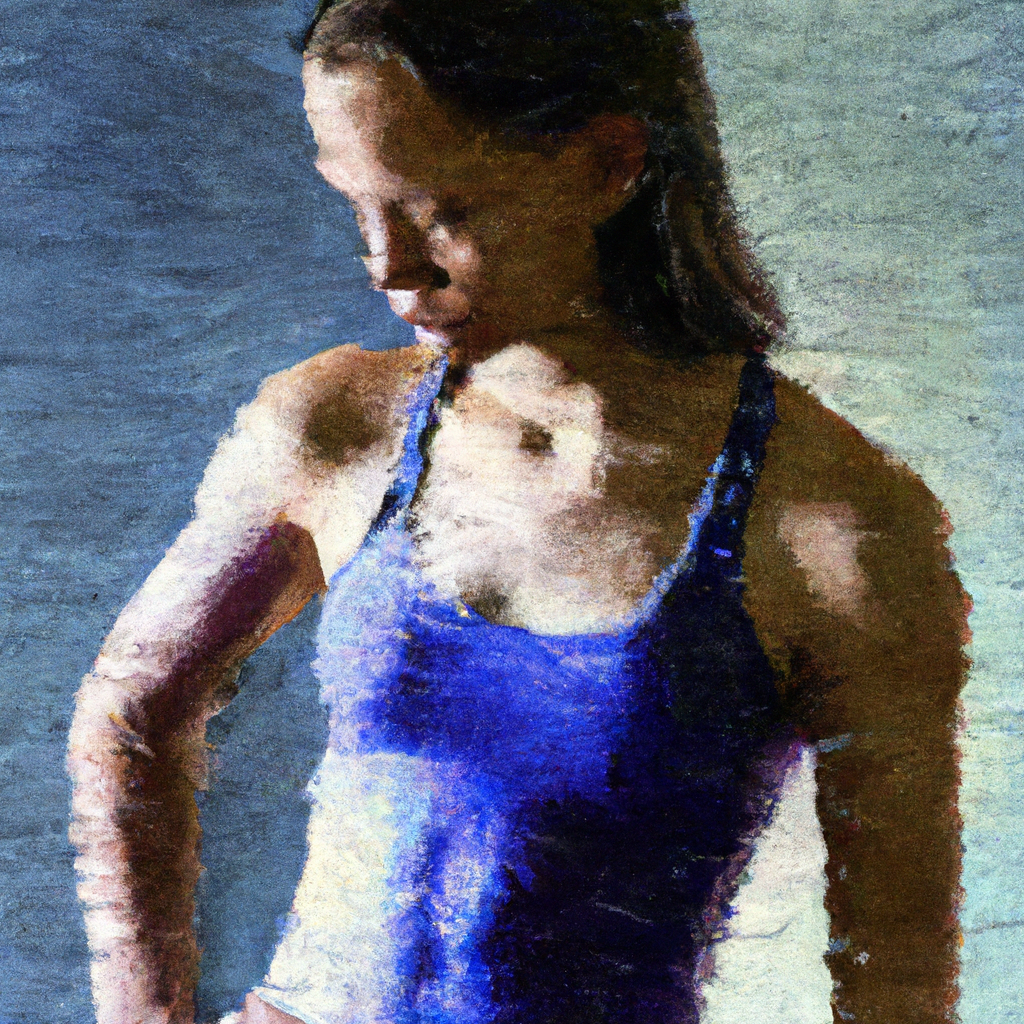

In [ ]:
img

In [ ]:
import openai
def test_dalle3(prompt: str, negative_prompt: str, aspect_ratio: str):
    """Generate image via DALL·E 3 API"""
    try:
        response = openai.Image.create(
            model="dall-e-3",
            prompt=f"{prompt} [NEG: {negative_prompt}] --ar {aspect_ratio}",
            size="1024x1024",  # DALL·E 3 max size
            quality="hd"
        )
        img_url = response.data[0].url
        img = Image.open(requests.get(img_url, stream=True).raw)
        img.save(f"{OUTPUT_DIR}/dalle3_output.png")
        return img
    except Exception as e:
        print(f"DALL·E 3 Error: {str(e)}")
        return None

In [ ]:
negeative = "cartoonish, smooth textures, oversaturated colors, plastic skin, low contrast, symmetry, anime"

In [ ]:
test_dalle3(optimized_prompt,negeative,aspect_ratio="0.2")

In [ ]:
optimized_prompt

'\n        (painting of a muscular teenage girl in weathered blue bathing suit:1.4),\n        (dimly lit room with #8e9098, #252940, #c7c0c1, #134881, #646774 color palette:1.3),\n        (textured brushstrokes style of fenghua zhong:1.3),\n        (George Bellows realism, Hendrick Terbrugghen chiaroscuro:1.2),\n        (weathered skin, coarse canvas texture:1.2),\n        (high contrast lighting [contrast=189.4306]:1.3),\n        (edge density 0.0345, homogeneity 0.2284:1.1),\n        (William Twigg-Smith tonalism:1.1),\n        aspect ratio 936:1210, 8k resolution, saatchi art gallery style\n    '

In [ ]:
import os
import openai
from PIL import Image
import requests
import numpy as np
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from skimage.metrics import structural_similarity as ssim
import cv2

# Configuration
TEST_PROMPT = "painting of a muscular teenage girl in weathered blue bathing suit, muted palette (#8e9098), textured brushstrokes, 8k resolution"
NEGATIVE_PROMPT = "cartoon, smoothness, saturation, symmetry, anime"
ASPECT_RATIO = "936:1210"
OUTPUT_DIR = "generated_images"
MODELS_TO_TEST = ["dalle3", "stable_diffusion"]  # MidJourney requires Discord bot setup

# Initialize APIs
openai.api_key = os.getenv("OPENAI_API_KEY")  # Add your key to environment variables

def test_dalle3(prompt: str, negative_prompt: str, aspect_ratio: str):
    """Generate image via DALL·E 3 API"""
    try:
        response = openai.Image.create(
            model="dall-e-3",
            prompt=f"{prompt} [NEG: {negative_prompt}] --ar {aspect_ratio}",
            size="1024x1024",  # DALL·E 3 max size
            quality="hd"
        )
        img_url = response.data[0].url
        img = Image.open(requests.get(img_url, stream=True).raw)
        img.save(f"{OUTPUT_DIR}/dalle3_output.png")
        return img
    except Exception as e:
        print(f"DALL·E 3 Error: {str(e)}")
        return None

def test_stable_diffusion(prompt: str, negative_prompt: str, aspect_ratio: str):
    """Generate image using Stable Diffusion + ControlNet"""
    try:
        width, height = map(int, aspect_ratio.split(":"))

        # Initialize pipeline
        controlnet = ControlNetModel.from_pretrained(
            "lllyasviel/sd-controlnet-canny",
            torch_dtype=torch.float16
        )
        pipe = StableDiffusionControlNetPipeline.from_pretrained(
            "runwayml/stable-diffusion-v1-5",
            controlnet=controlnet,
            torch_dtype=torch.float16
        ).to("cuda")

        # Dummy edge map (replace with real preprocessing if needed)
        dummy_image = np.zeros((height, width, 3), dtype=np.uint8)
        edges = cv2.Canny(dummy_image, 100, 200)
        edge_image = Image.fromarray(edges)

        # Generate
        image = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            image=edge_image,
            width=width,
            height=height,
            guidance_scale=7.5,
            num_inference_steps=30
        ).images[0]

        image.save(f"{OUTPUT_DIR}/stable_diffusion_output.png")
        return image
    except Exception as e:
        print(f"Stable Diffusion Error: {str(e)}")
        return None

def test_midjourney(prompt: str):
    """MidJourney emulation (requires Discord bot setup)"""
    print("MidJourney integration requires Discord bot implementation.")
    print("Refer to: https://github.com/alfonmga/midjourney-discord-bot")
    return None

def compare_results(source_image_path: str, generated_images: dict):
    """Compare outputs using SSIM"""
    src_img = cv2.imread(source_image_path)
    results = {}

    for model_name, img_path in generated_images.items():
        gen_img = cv2.imread(img_path)
        gen_img = cv2.resize(gen_img, (src_img.shape[1], src_img.shape[0]))
        score = ssim(src_img, gen_img, multichannel=True)
        results[model_name] = score

    print("\n=== Comparison Results ===")
    for model, score in results.items():
        print(f"{model}: {score:.2%} similarity")
    return results

if __name__ == "__main__":
    # Create output directory
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Test models
    generated = {}

    if "dalle3" in MODELS_TO_TEST:
        print("Testing DALL·E 3...")
        dalle_img = test_dalle3(TEST_PROMPT, NEGATIVE_PROMPT, ASPECT_RATIO)
        if dalle_img:
            generated["dalle3"] = f"{OUTPUT_DIR}/dalle3_output.png"

    if "stable_diffusion" in MODELS_TO_TEST:
        print("Testing Stable Diffusion...")
        sd_img = test_stable_diffusion(TEST_PROMPT, NEGATIVE_PROMPT, ASPECT_RATIO)
        if sd_img:
            generated["stable_diffusion"] = f"{OUTPUT_DIR}/stable_diffusion_output.png"

    if "midjourney" in MODELS_TO_TEST:
        print("Testing MidJourney...")
        test_midjourney(TEST_PROMPT)

    # Compare results (if source image available)
    SOURCE_IMAGE = "source_image.jpg"  # Update path
    if os.path.exists(SOURCE_IMAGE) and generated:
        compare_results(SOURCE_IMAGE, generated)

In [ ]:
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

def upscale_image(image_path, output_path):
    model = RRDBNet(num_in_feat=3, num_out_feat=3, num_feat=64, num_block=23, num_grow_ch=32)
    upsampler = RealESRGANer(scale=4, model_path="weights/RealESRGAN_x4plus.pth", model=model)
    img = cv2.imread(image_path)
    output, _ = upsampler.enhance(img, outscale=4)
    cv2.imwrite(output_path, output)

upscale_image("recreated_image.png", "recreated_image_4k.png")

In [ ]:
def adjust_colors(source_path, generated_path, output_path):
    src = cv2.imread(source_path)
    gen = cv2.imread(generated_path)

    # Apply histogram matching
    src_hist = cv2.calcHist([src], [0,1,2], None, [256,256,256], [0,256, 0,256, 0,256])
    gen_hist = cv2.calcHist([gen], [0,1,2], None, [256,256,256], [0,256, 0,256, 0,256])

    # Match histograms
    matched = cv2.LUT(gen, src_hist / gen_hist)
    cv2.imwrite(output_path, matched)